In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [4]:
def sample_exponential(l):
    u = np.random.random()
    d_t = -np.log(1-u) / l
    return d_t

class population:
    # beta is infection rate while gamma is recover rate. 
    def __init__(self, _n, _i, _inf_propensity, _rec_propensity, _r=0):
        self.n = _n
        self.i = _i
        self.r = _r
        self.s = self.n - self.i - self.r
        # propensity is constant
        # infection propensity:
        self.INF_P = _inf_propensity
        # recover propensity:
        self.REC_P = _rec_propensity
        self.total_transition_rate = (self.INF_P * self.i / self.n * self.s + self.REC_P * self.i)
    
    def update_state(self, event:str):
        if( event == 'infected'):
            self.s -= 1
            self.i += 1
        elif( event == 'recovered'):
            self.i -= 1
            self.r += 1
        else:
            raise Exception("No such event.")
        self.total_transition_rate = (self.INF_P * self.i * self.s + self.REC_P * self.i)
        
    def update_states(self, eventNum:int, event:str):
        if( event == 'infected'):
            if(eventNum > self.s):
                eventNum = self.s
            self.s -= eventNum
            self.i += eventNum
        elif( event == 'recovered'):
            if(eventNum > self.i):
                eventNum = self.i
            self.i -= eventNum
            self.r += eventNum
        else:
            raise Exception("No such event.")
        self.total_transition_rate = (self.INF_P * self.i * self.s + self.REC_P * self.i)

    def sample_individual(self):
        u = np.random.random()
        if( u <= ( self.REC_P * self.i / self.total_transition_rate)):
            return "recovered"
        else:
            return "infected"
import copy
def simulate_SIR_gillespie (po:population, cycles : int,steps:int, X, S, I, R):
    current_cycle = 0
    
    while ( current_cycle < cycles):
        _p = copy.deepcopy(po)
        current_step = 0
        while (current_step < steps):
            # choose which type of events happened. 
            event = _p.sample_individual()
            # update population state
            _p.update_state(event)

            # if the exponential distribution of the time is nearly flat, it means it would take super long time 
            # for next event to happen. Then we just stop our simulation.
            if(_p.total_transition_rate <= 1.0e-4):
                X[current_cycle, current_step + 1:] = X[current_cycle, current_step]
                S[current_cycle, current_step + 1:] = S[current_cycle, current_step]
                I[current_cycle, current_step + 1:] = I[current_cycle, current_step]
                R[current_cycle, current_step + 1:] = R[current_cycle, current_step]
                break
            # How long time does this type of event happen take? 
            d_t = sample_exponential(_p.total_transition_rate)

            # print(f'===== The {current_step} iteration is a {event} event after time {d_t}.===== ')
            # print(vars(_p))

            # Take a record after a single conversion event. 
            X[current_cycle, current_step + 1] = X[current_cycle, current_step] + d_t
            S[current_cycle, current_step + 1] = _p.s
            I[current_cycle, current_step + 1] = _p.i
            R[current_cycle, current_step + 1] = _p.r
            current_step += 1
        current_cycle +=1

def simulate_SIR_tau_leaping (po:population, cycles:int, steps:int, tau, X, S, I, R):
    current_cycle = 0
    while ( current_cycle < cycles):
        _p = copy.deepcopy(po)
        current_step = 0
        while (current_step < steps):
            # Set how many times each event happens in givel tau time. 
            ni = poisson.ppf(np.random.random(), _p.INF_P * _p.i * _p.s * tau)
            nr = poisson.ppf(np.random.random(), _p.REC_P * _p.i * tau)
            # update population state
            _p.update_states(ni, "infected")
            _p.update_states(nr, "recovered")

            # if the exponential distribution of the time is nearly flat, it means it would take super long time 
            # for next event to happen. Then we just stop our simulation.
            if(_p.total_transition_rate <= 1.0e-4):
                X[current_cycle, current_step + 1:] = X[current_cycle, current_step]
                S[current_cycle, current_step + 1:] = S[current_cycle, current_step]
                I[current_cycle, current_step + 1:] = I[current_cycle, current_step]
                R[current_cycle, current_step + 1:] = R[current_cycle, current_step]
                break

            # Take a record after a single conversion event. 
            X[current_cycle, current_step + 1] = X[current_cycle, current_step] + tau
            S[current_cycle, current_step + 1] = _p.s
            I[current_cycle, current_step + 1] = _p.i
            R[current_cycle, current_step + 1] = _p.r
            current_step += 1
        current_cycle +=1

def simulate_SIR_hybrid():
    pass

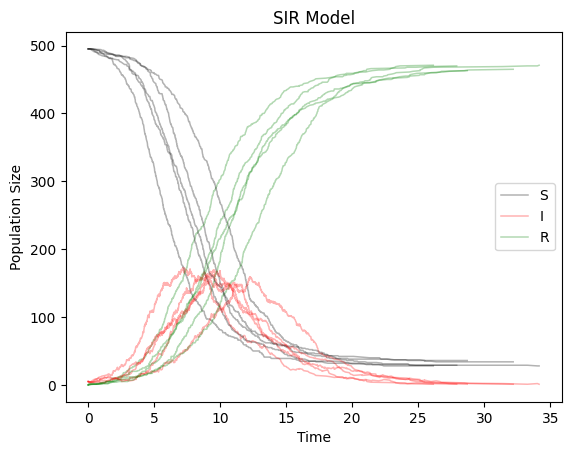

R infinity for Gillespie on average is 468.0. 


In [21]:
# Set repetition cycles and each simulation steps. 
cycles = 5
steps = 1200

# Set record tables. 
po = population(500, 5, 1.0/500.0, 1./3.)
X = np.zeros((cycles, steps + 1))
X[:, 0] = 0
S = np.zeros((cycles, steps + 1))
S[:, 0] = po.s
I = np.zeros((cycles, steps + 1))
I[:, 0] = po.i
R = np.zeros((cycles, steps + 1))
R[:, 0] = po.r

simulate_SIR_gillespie(po, cycles, steps, X, S, I, R)

for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')

plt.plot(X[-1, :], S[-1, :], linewidth = 1.1, alpha = 0.3, color = 'black', label = 'S')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("SIR Model")
plt.show()

print(f'R infinity for Gillespie on average is {np.average(R[:, -1])}. ')

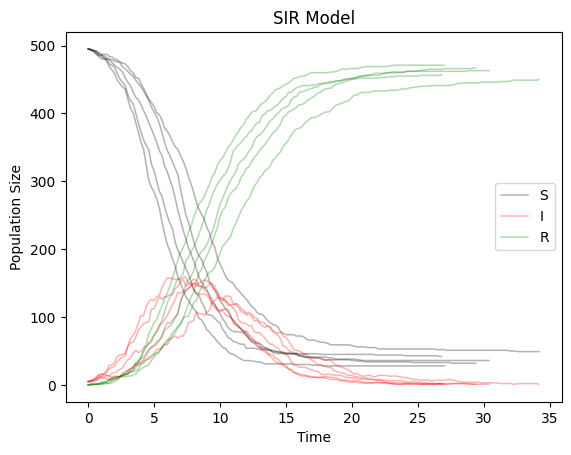

R infinity for tau leaping on average is 461.6. 


In [22]:
# Set repetition cycles and each simulation steps. 
cycles = 5
steps = 1200

# Set record tables. 
po = population(500, 5, 1.0/500.0, 1./3.)
X = np.zeros((cycles, steps + 1))
X[:, 0] = 0
S = np.zeros((cycles, steps + 1))
S[:, 0] = po.s
I = np.zeros((cycles, steps + 1))
I[:, 0] = po.i
R = np.zeros((cycles, steps + 1))
R[:, 0] = po.r

simulate_SIR_tau_leaping(po, cycles, steps, 0.2, X, S, I, R)

for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')

plt.plot(X[-1, :], S[-1, :], linewidth = 1.1, alpha = 0.3, color = 'black', label = 'S')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("SIR Model")
plt.show()

print(f'R infinity for tau leaping on average is {np.average(R[:, -1])}. ')

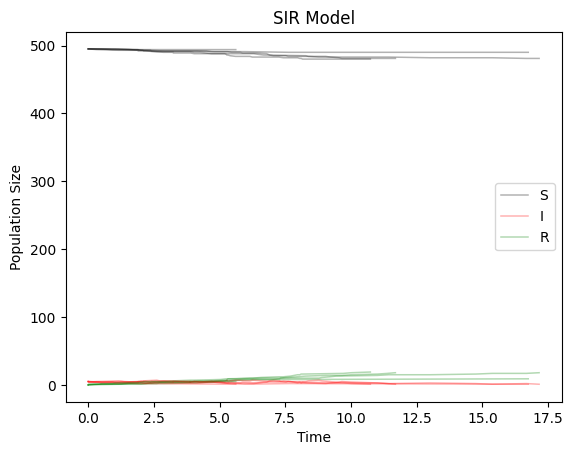

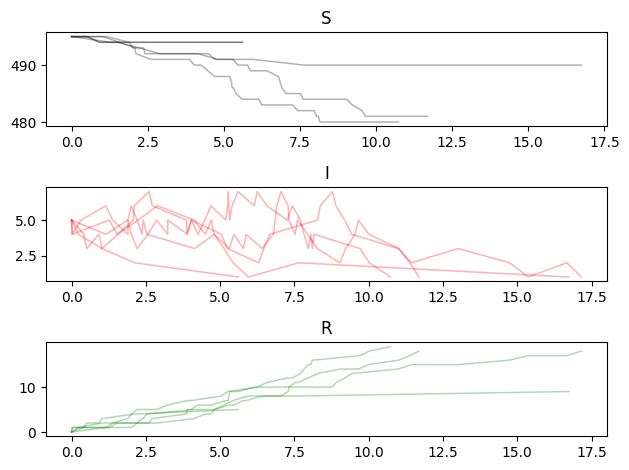

R infinity for Gillespie on average with beta = 1/2000 is 13.8. 


In [18]:
cycles = 5
steps = 1000

po = population(500, 5, 1./2000., 1./3.)
X = np.zeros((cycles, steps + 1))
X[:, 0] = 0
S = np.zeros((cycles, steps + 1))
S[:, 0] = po.s
I = np.zeros((cycles, steps + 1))
I[:, 0] = po.i
R = np.zeros((cycles, steps + 1))
R[:, 0] = po.r

simulate_SIR_gillespie(po, cycles, steps, X, S, I, R)

for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')

plt.plot(X[-1, :], S[-1, :], linewidth = 1.1, alpha = 0.3, color = 'black', label = 'S')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("SIR Model")

plt.figure()
plt.subplot(3,1,1)
for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
plt.title('S')
plt.subplot(3,1,2)
for i in range(cycles-1):
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.title('I')
plt.subplot(3,1,3)
for i in range(cycles-1):
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')
plt.title('R')
plt.tight_layout()
plt.show()

print(f'R infinity for Gillespie on average with beta = 1/2000 is {np.average(R[:, -1])}. ')

Problem1. R(inf) = 468.0 for tradition Gillespie algorithm.

Problem2. R(inf) = 461.1 for tao-leaping algorithm with tao = 0.2. There is no substantial discrepandcy. 

Problem3. I find Inflected population first grow and the decrease. Few people were inflected. The epidemic can still persist because it needs some time for all inflected population to recover. And during this time there will be more people being inflected. 

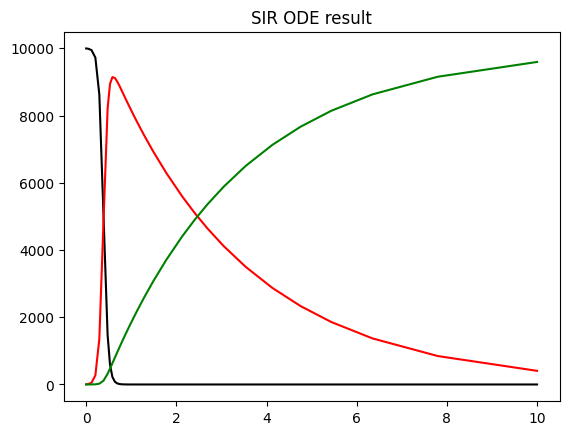

In [45]:
from scipy import integrate

po_large = population(10000, 5, 1./500, 1./3.)

# ODE solver for the inflection process. 
beta = po_large.INF_P
gamma = po_large.REC_P
N = po_large.n

def func(t, sir):
    return [-beta * N * sir[0] * sir[1], beta * N * sir[0] * sir[1] - gamma * sir[1], gamma * sir[1]]

sol = integrate.solve_ivp(func, [0, 10], [po_large.s/po_large.n, po_large.i/po_large.n, po_large.r/po_large.n])

plt.plot(sol.t, sol.y[0] * N, linewidth = 1.5, color = 'black', label = 'S')
plt.plot(sol.t, sol.y[1] * N, linewidth = 1.5, color = 'red', label = 'I')
plt.plot(sol.t, sol.y[2] * N, linewidth = 1.5, color = 'green', label = 'R')
plt.title('SIR ODE result')
plt.show()



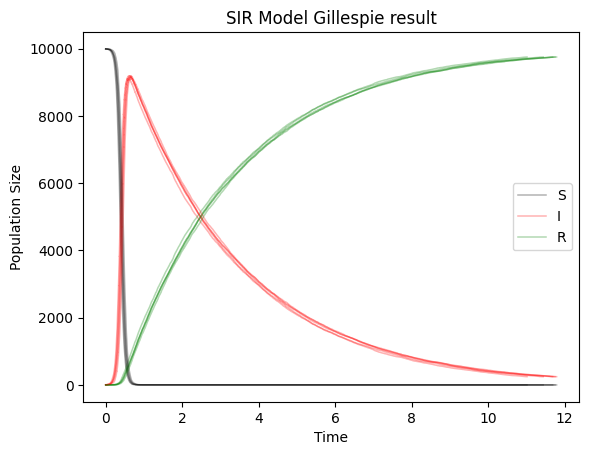

In [43]:
# Gillespie result. 
cycles = 5
steps = 19750
X = np.zeros((cycles, steps + 1))
X[:, 0] = 0
S = np.zeros((cycles, steps + 1))
S[:, 0] = po_large.s
I = np.zeros((cycles, steps + 1))
I[:, 0] = po_large.i
R = np.zeros((cycles, steps + 1))
R[:, 0] = po_large.r
simulate_SIR_gillespie(po_large, cycles, steps, X, S, I, R)

for i in range(cycles-1):
    plt.plot(X[i, :], S[i, :], linewidth = 1.1, alpha = 0.3, color = 'black')
    plt.plot(X[i, :], I[i, :], linewidth = 1.1, alpha = 0.3, color = 'red')
    plt.plot(X[i, :], R[i, :], linewidth = 1.1, alpha = 0.3, color = 'green')

plt.plot(X[-1, :], S[-1, :], linewidth = 1.1, alpha = 0.3, color = 'black', label = 'S')
plt.plot(X[-1, :], I[-1, :], linewidth = 1.1, alpha = 0.3, color = 'red', label = 'I')
plt.plot(X[-1, :], R[-1, :], linewidth = 1.1, alpha = 0.3, color = 'green', label = 'R')

plt.legend()
plt.xlabel("Time")
plt.ylabel("Population Size")
plt.title("SIR Model Gillespie result")
plt.show()

Problem 4. The result discrepancies are not obvious, however, it takes way more longer to use gillespie for a large population because every sampled time is extremly small due to the large summation of lambda(since the distribution of t for an event to occur is an exponential with lambda = sum of lambda for every indivisual).  

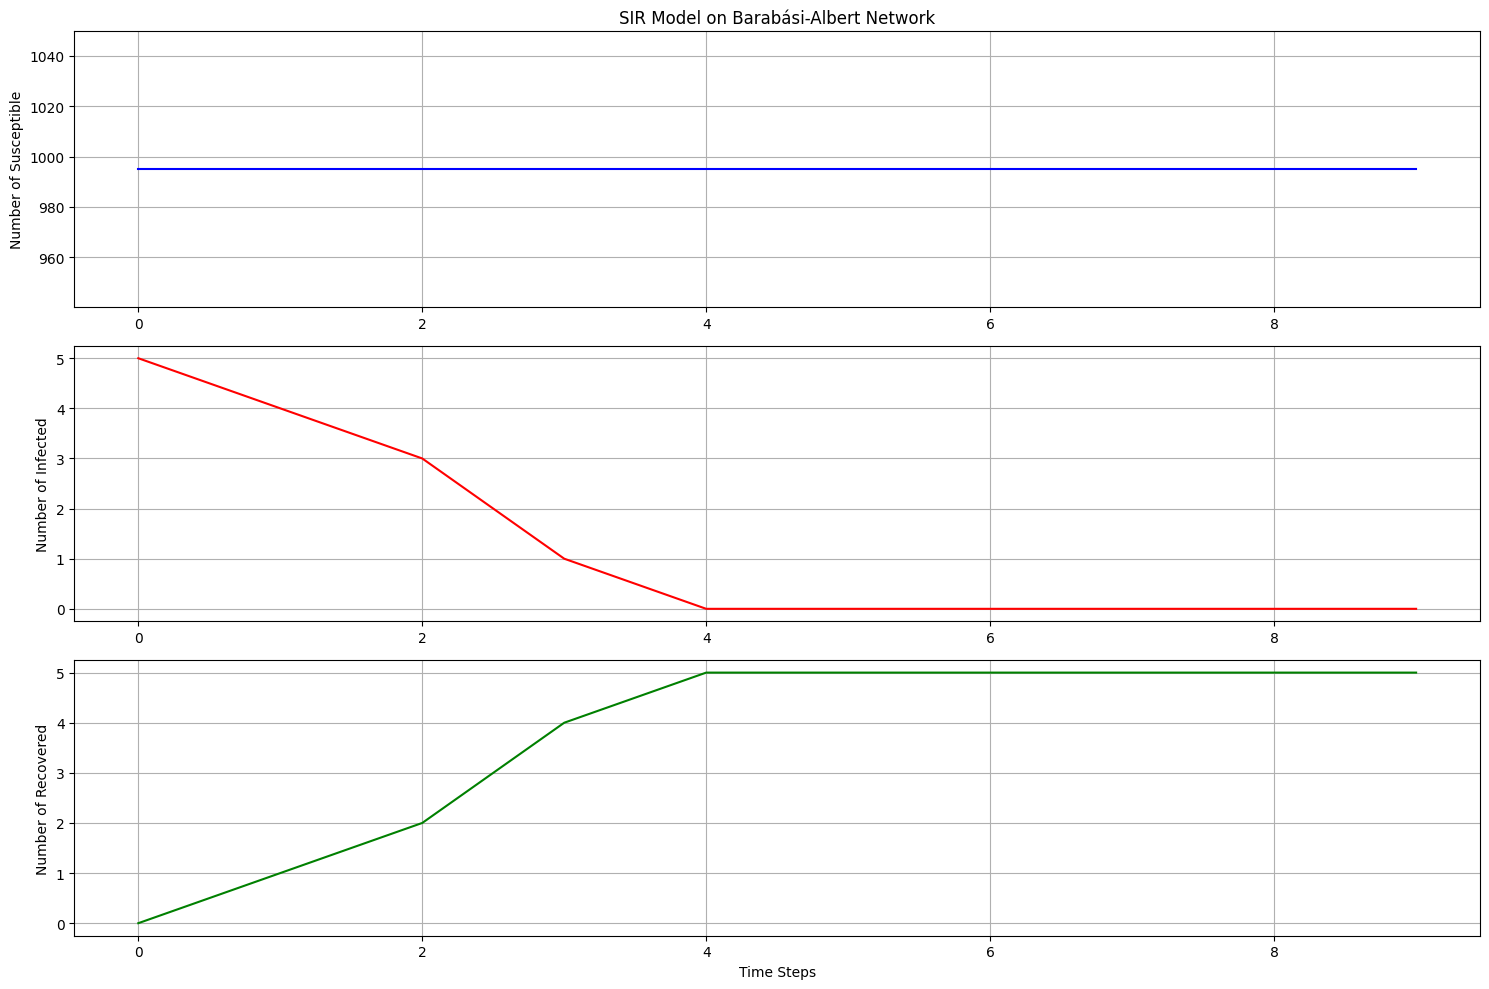

In [75]:
import networkx as nx

def create_ba_network(n, m):
    return nx.barabasi_albert_graph(n, m)

def initialize_sir(G, initial_infected):
    """Initialize the SIR model."""
    node_count = G.number_of_nodes()
    state = {node: 'S' for node in G.nodes()}  # All nodes are susceptible
    infected_nodes = np.random.choice(G.nodes(), initial_infected, replace=False)
    for node in infected_nodes:
        state[node] = 'I'  # Infect initial nodes
    return state

def step_sir(G, state, beta, gamma):
    """Perform one time step of the SIR model."""
    new_state = state.copy()
    for node in G.nodes():
        if state[node] == 'I':
            # Spread infection to susceptible neighbors
            for neighbor in G.neighbors(node):
                if state[neighbor] == 'S' and np.random.rand() < beta:
                    new_state[neighbor] = 'I'
            # Move infected to recovered
            if np.random.rand() < gamma:
                new_state[node] = 'R'
    return new_state

def simulate_sir(G, initial_infected, beta, gamma, time_steps):
    """Simulate the SIR model over a specified number of time steps."""
    state = initialize_sir(G, initial_infected)
    history = []
    
    for t in range(time_steps):
        history.append(state.copy())
        state = step_sir(G, state, beta, gamma)
    
    return history

def plot_results(history):
    """Plot the results of the SIR simulation."""
    time_steps = len(history)
    susceptible_counts = []
    infected_counts = []
    recovered_counts = []
    
    for state in history:
        susceptible_count = sum(1 for s in state.values() if s == 'S')
        infected_count = sum(1 for s in state.values() if s == 'I')
        recovered_count = sum(1 for s in state.values() if s == 'R')
        
        susceptible_counts.append(susceptible_count)
        infected_counts.append(infected_count)
        recovered_counts.append(recovered_count)
    
    # Create subplots
    plt.figure(figsize=(15, 10))
    
    # Susceptible subplot
    plt.subplot(3, 1, 1)
    plt.plot(susceptible_counts, label='Susceptible', color='blue')
    plt.ylabel('Number of Susceptible')
    plt.title('SIR Model on Barabási-Albert Network')
    plt.grid(True)
    
    # Infected subplot
    plt.subplot(3, 1, 2)
    plt.plot(infected_counts, label='Infected', color='red')
    plt.ylabel('Number of Infected')
    plt.grid(True)

    # Recovered subplot
    plt.subplot(3, 1, 3)
    plt.plot(recovered_counts, label='Recovered', color='green')
    plt.ylabel('Number of Recovered')
    plt.xlabel('Time Steps')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Parameters
n = 1000       # Number of nodes
m = 3          # Number of edges to attach from a new node to existing nodes
initial_infected = 5
beta = 1./2000.     # Infection probability
gamma = 1./3.    # Recovery probability
time_steps = 10

# Create the network and simulate the SIR model
G = create_ba_network(n, m)
history = simulate_sir(G, initial_infected, beta, gamma, time_steps)

# Plot results
plot_results(history)

Problem5. This, compared to problem3, gives a smooth result. I think this is because in gillespie algorithm, an event could happen after a long time interval, causing a sudden change in the result while in BA model, this situation does not happen. 